By Riley Stange
<br>For Thinkful Capstone 1: Business Research
<br>Dataset Sourced from https://www.kaggle.com/rush4ratio/video-game-sales-with-ratings
<br>Cleaning: Changed anything with the now obsolete rating of 'K-A' to 'E', since they are considered equivalent.

In [98]:
import math
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="darkgrid")

In [99]:
sales = pd.read_csv('~/projects/video-game-sales-by-maturity-rating/Video_Games_Sales_as_at_22_Dec_2016.csv')

In [100]:
# Only pull from entries where there are US sales
# and where there is a rating
na_sales = sales[(sales['NA_Sales'] > 0) & (sales.Rating.notnull())]

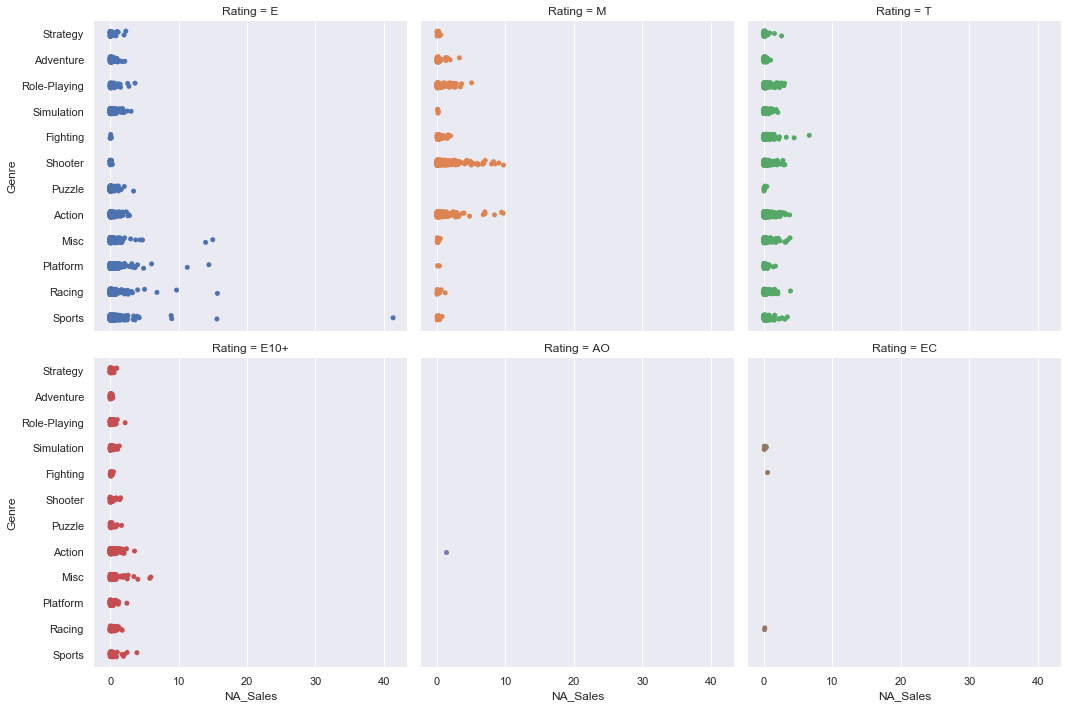

In [101]:
sns.catplot(x='NA_Sales', y='Genre', hue='Rating', col='Rating',
            col_wrap=3, data=na_sales)
plt.show()

It appears that there are a few outliers:
<br>One occuring above 41 million in the Sports category on the Rating = E chart
<br>Another occuring around 1 million in the Action category on the Rating = AO chart
<br>And a few in only the perhaps 10s of thousands across Simulation, Fighting, and Racing categories in the EC chart.
<br>These are infrequent occurences and should be excluded to get a better picture of the other charts.
<br>It is also important to note that the EC rating was retired in 2018, further confirming it's present-day irrelevance.

In [102]:
# Eliminating extreme outliers of sales more than 30 million,
# and Adult Only/Early Childhood rated entries.

na_sales_e_to_m = sales[ (sales['NA_Sales'] > 0) 
                       & (sales['NA_Sales'] < 30) 
                       & (sales.Rating.notnull()) 
                       & (sales['Rating'] != 'AO') 
                       & (sales['Rating'] != 'EC')]

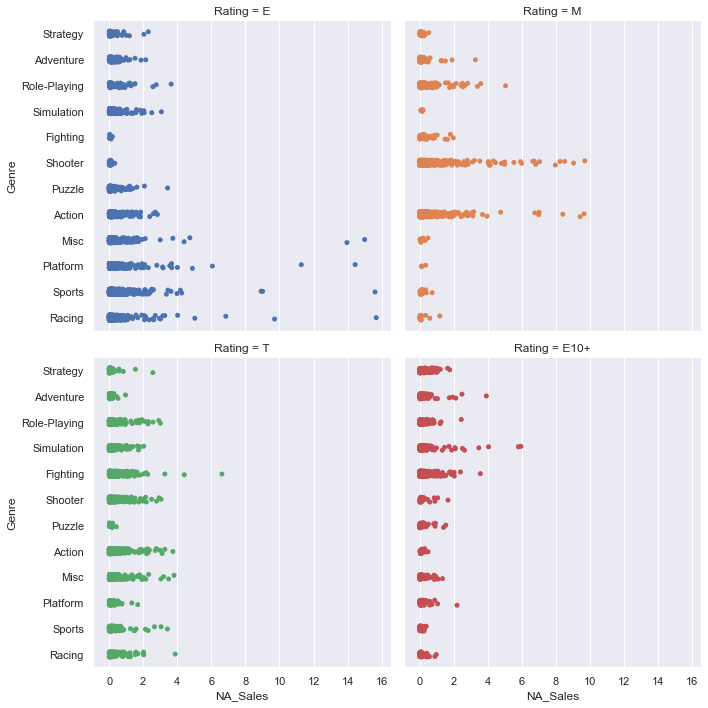

In [103]:
sns.catplot(x='NA_Sales',y='Genre', hue='Rating', col='Rating', col_wrap=2, data=na_sales_e_to_m)
plt.show()
#